TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([3, 25]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        done_mask: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.bool, is_shared=False),
        edges: Tensor(shape=torch.Size([3, 25, 25]), device=cpu, dtype=torch.bool, is_shared=False),
        end_node: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.int64, is_shared=False),
        first_node: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        invalid_mask: Tensor(shape=torch.Size([3, 25]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([3, 25, 2]), device=cpu, dtype=torch.float32, i

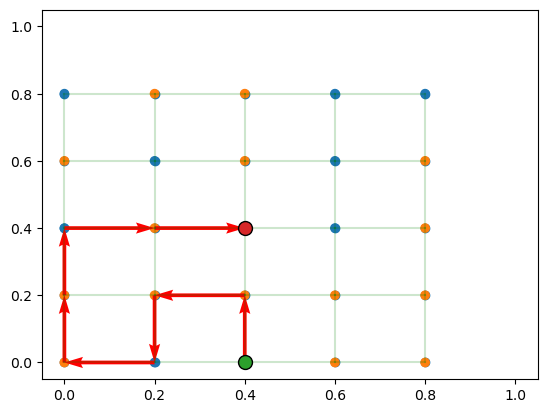

In [3]:
from SPPDynamicEnv import SPPDynamicEnv
from utils import rollout, random_policy

batch_size = 3

env = SPPDynamicEnv(num_loc=25)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
env.render(td, actions)

In [2]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy
env = SPPDynamicEnv(num_loc=100)

# Instantiate policy with the embeddings we created above
emb_dim = 64
# policy = AutoregressivePolicy(env,
#                               embedding_dim=emb_dim,
#                               init_embedding=SPPInitEmbedding(emb_dim),
#                               context_embedding=SPPContext(emb_dim),
#                               dynamic_embedding=StaticEmbedding(emb_dim)


# model = AttentionModel(env, baseline="rollout",
#                        policy=policy,
#                        train_data_size=100_000,
#                        val_data_size=100_00,
#                        optimizer_kwargs= {"lr": 1e-4},)

policy = POMOPolicy(env,
                    embedding_dim=emb_dim,
                    init_embedding=SPPInitEmbedding(emb_dim),
                    context_embedding=SPPContext(emb_dim),
                    dynamic_embedding=StaticEmbedding(emb_dim))

model = POMO(env, policy=policy,
             baseline='shared',
             batch_size=3,
             train_data_size=100_0,
             val_data_size=100)

# Model: default is AM with REINFORCE and greedy rollout baseline
# model = AttentionModel(env,
#                        policy=policy,
#                        baseline='rollout',
#                        train_data_size=100_0,
#                        val_data_size=100,)

/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


model took a step without hitting inval mask
invalid_mask tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, 

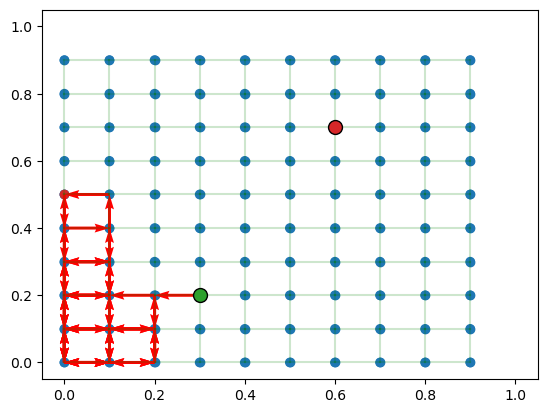

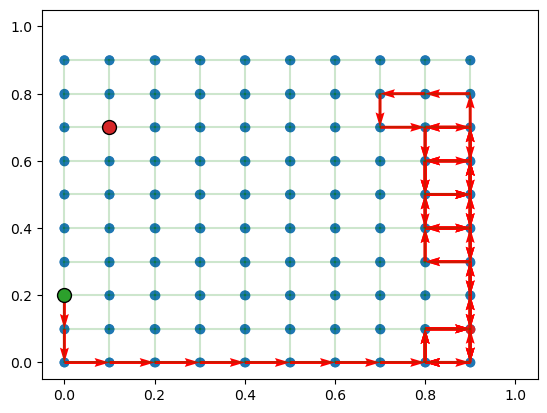

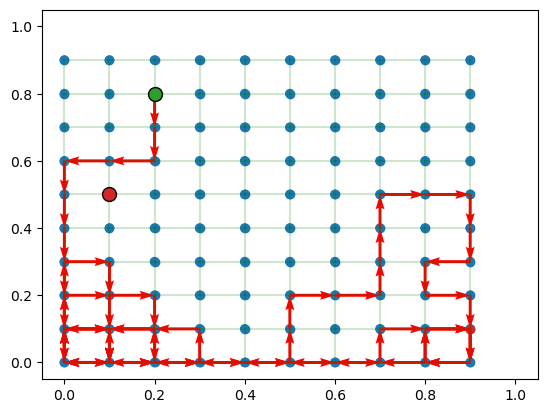

In [3]:
import torch

device = torch.device(device = "mps" if torch.backends.mps.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [17]:
from rl4co.utils.trainer import RL4COTrainer
from lightning.fabric.accelerators.mps import MPSAccelerator


trainer = RL4COTrainer(
    max_epochs=1,
    accelerator= "mps",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Gene

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


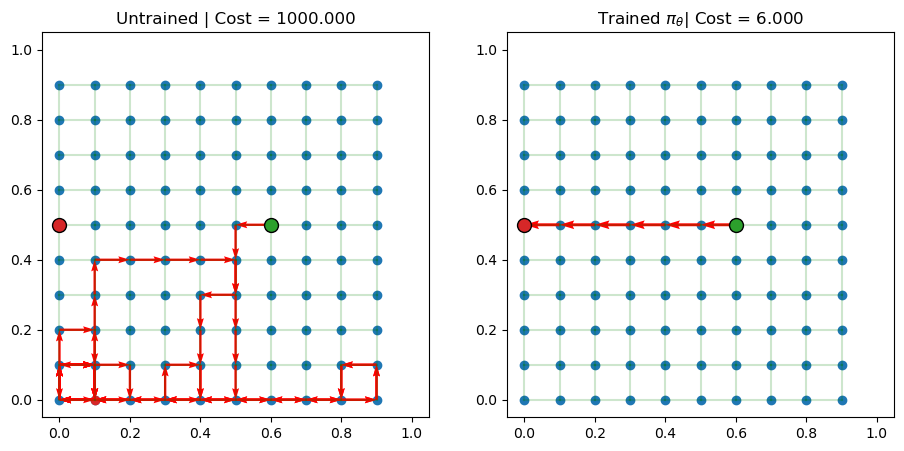

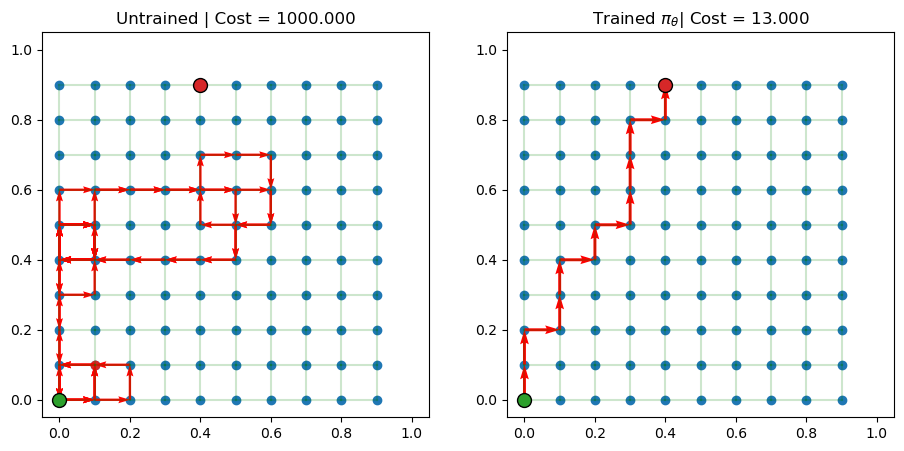

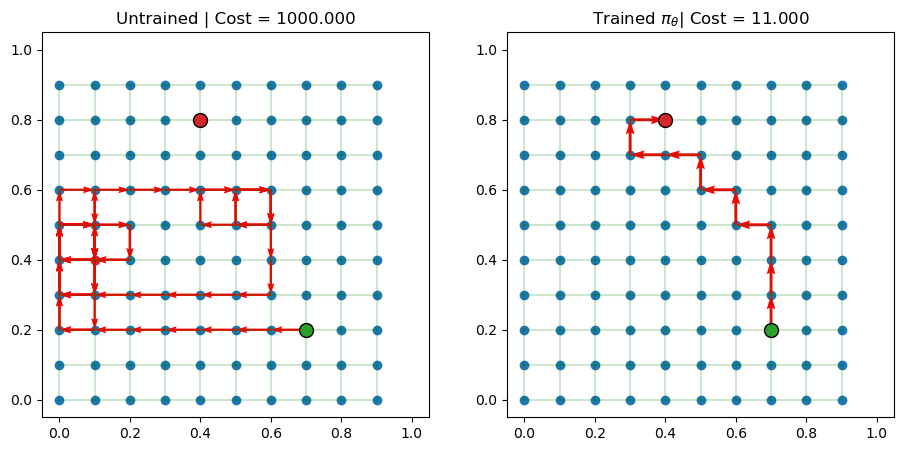

In [19]:
infer_env = SPPDynamicEnv(num_loc=1000)

model = model.to(device)
out = model(td_init.clone(),env=infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    infer_env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")